# Randomized & Bayes Search

Grid Search работает хорошо, когда у нас есть небольшое количество гиперпараметров и скорость обучения удовлетворяет нас. Однако, если у нас большой набор данных, большое количество гиперпараметров (например, 10х10) и мы используем кросс-валидацию на 5-10 фолдов, то потребуется 500 итераций обучения нашей модели, что очень-очень много.

Для оптимизации этого процесса используются две наиболее популярные техники: Randomized Search и Bayes Search

## Randomized Search

Алгоритм Randomized Search очень простой: случайным образом отбираются $n$ различных комбинаций гиперпараметров из их общего числа. Мы можем контроллировать значение $n$ и подбирать оптимальное для нас. Соответсвенно количество итераций обучения модели равно значению $n$. Аргумент, отвечающий за это значение называется $n$_$iters$

Как работает выбор комбинаций гиперпараметров? Это зависит от распределния вероятностей по диапазонам значений гиперпараметров.

Например:

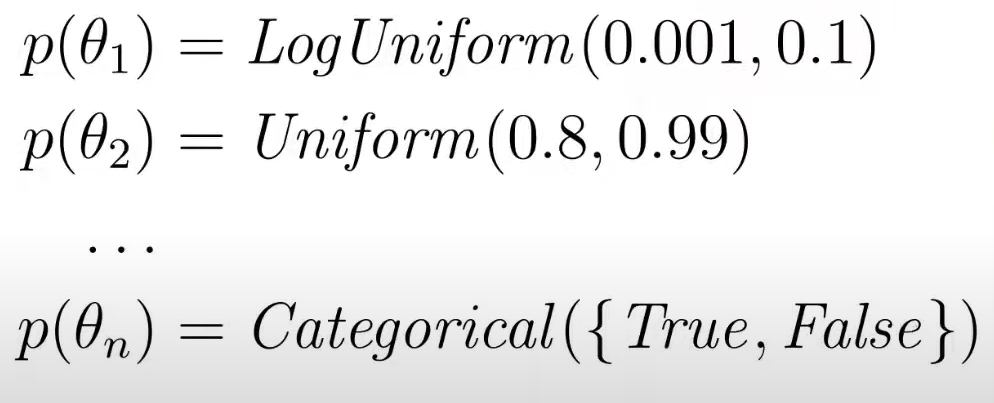

Далее из совместного распределения:

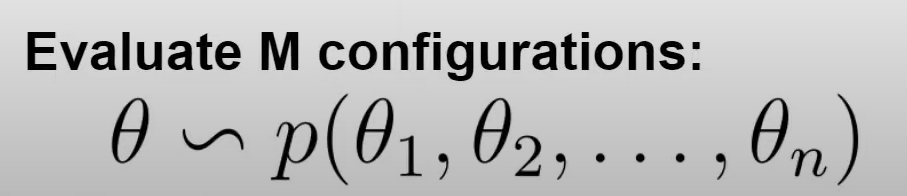

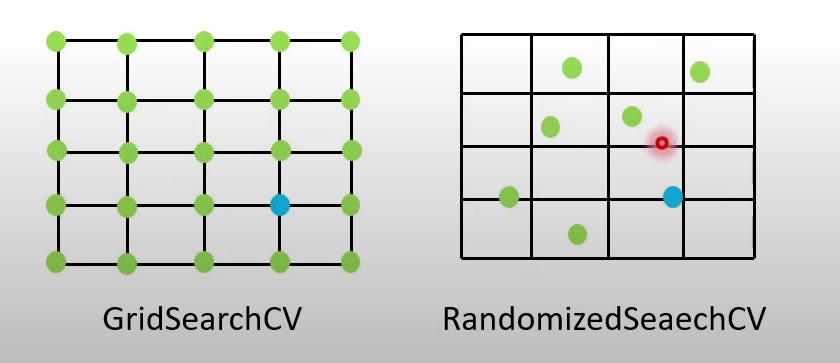

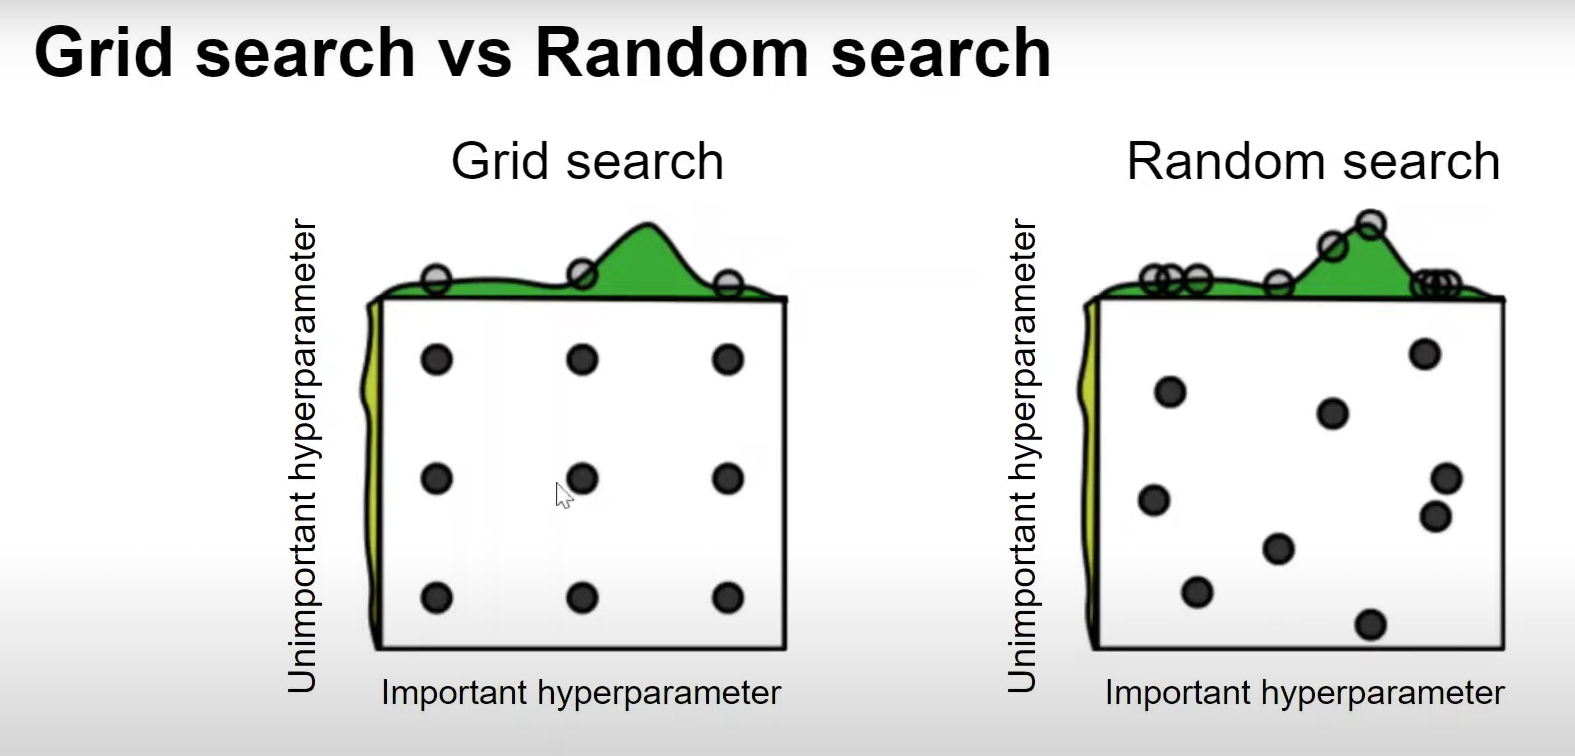

Для рисунка выше: Randomized Search более эффективен, когда у нас есть ненужные гиперпараметры

## Bayes Search

В отличие от Grid Search и Randomized Search, Bayes Search берёт в учёт предыдущие итерации обучения. Число итераций также устанавливаем мы. 

Сам процесс основан на теореме Байеса:

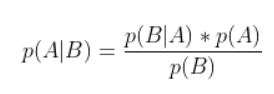

Если преобразовать:

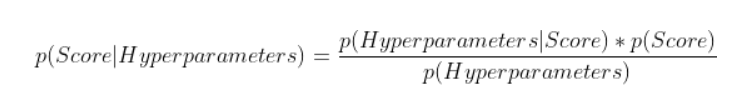

Проще говоря, этот метод создает вероятностную модель, в которой гиперпараметры сопоставляются с их соответствующей вероятностью скора. Вместо того, чтобы тщательно проверять каждый набор гиперпараметров или тестировать случайные наборы гиперпараметров, метод байесовской оптимизации сходится к оптимальным гиперпараметрам быстрее и точнее, не исследуя большое пространство выборки.

Можно провести аналогию с бэггингом и бустингом!

Основная идея такова: потратить немного больше времени на выбор следующих гиперпараметров, чтобы меньшее количество раз обучать модель.

Рассмотрим работу алгоритма

После двух оценок:

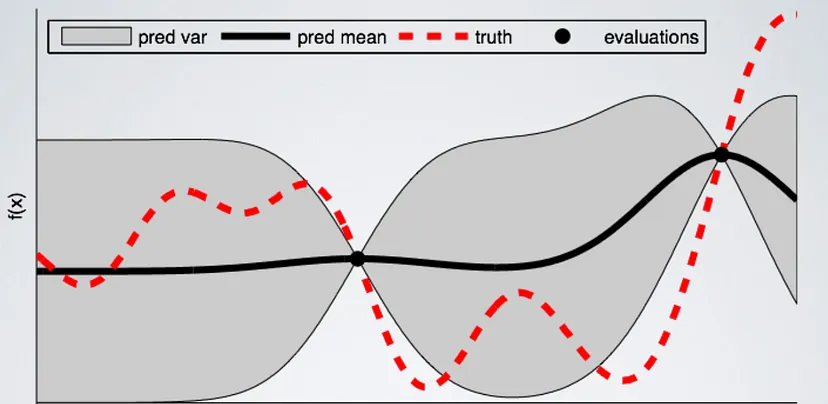

После 8 оценок:

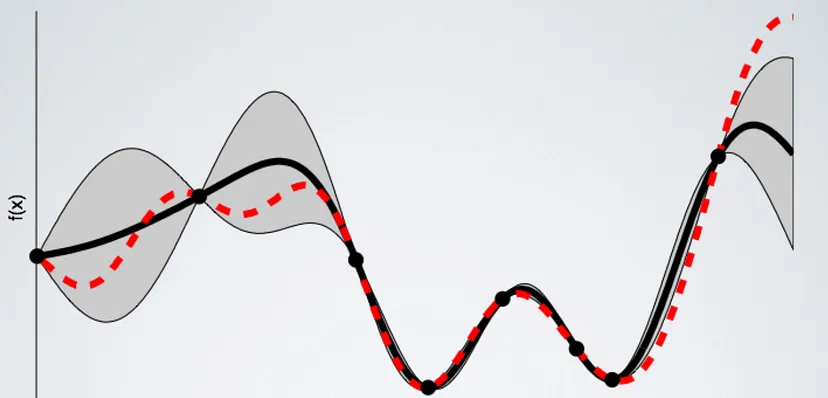

Мы формируем первоначальную картину модели (называемую априорной), а затем обновляем нашу модель на основе нового опыта (обновленная модель называется апостериорной)

### Grid Search

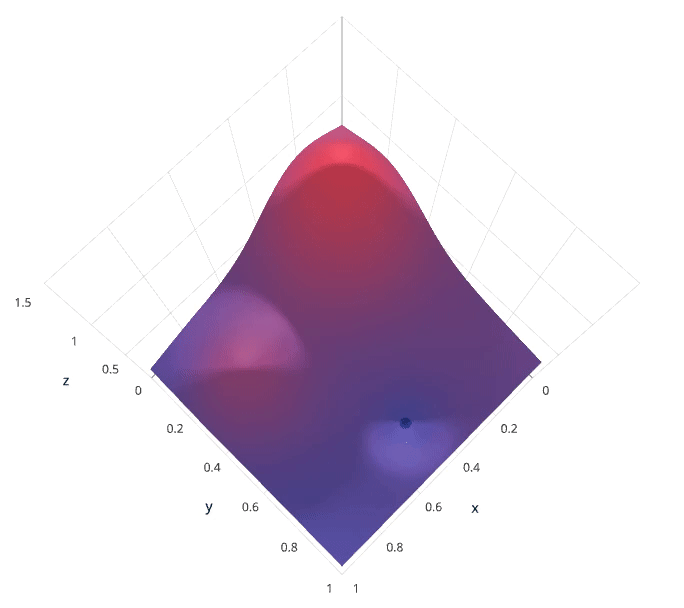

### Randomized Search

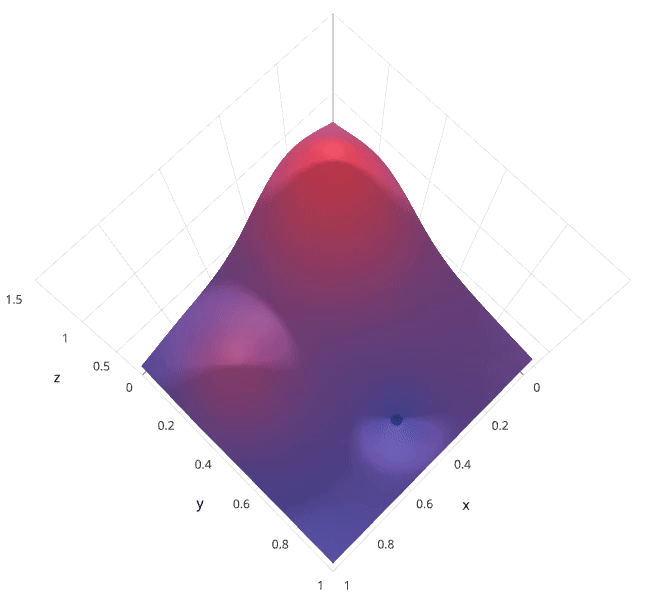

### Bayes Seacrh

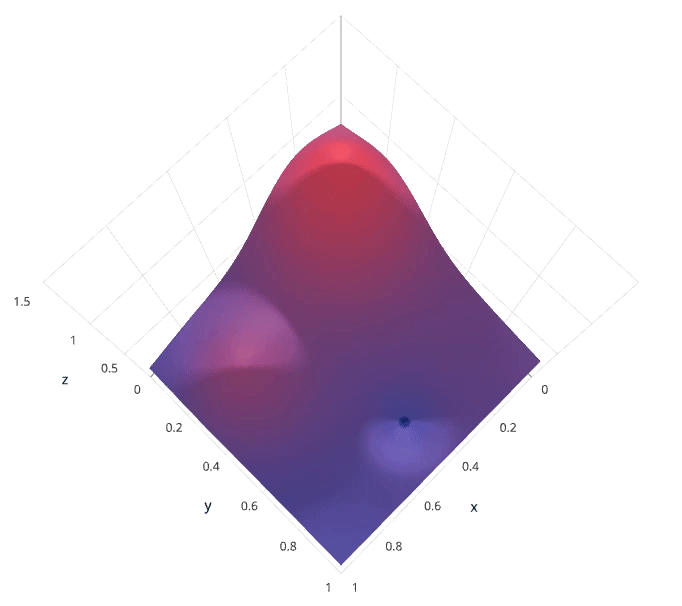

## Имплементация

### Датасет (задача - предсказать цену)

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
!wget -O 'train.csv' -q 'https://www.dropbox.com/s/tcvwgixnh9ixecd/car_price_pred.csv?dl=0'

In [ ]:
train = pd.read_csv('train.csv')
train.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [ ]:
train.isnull().any()

car_ID              False
symboling           False
CarName             False
fueltype            False
aspiration          False
doornumber          False
carbody             False
drivewheel          False
enginelocation      False
wheelbase           False
carlength           False
carwidth            False
carheight           False
curbweight          False
enginetype          False
cylindernumber      False
enginesize          False
fuelsystem          False
boreratio           False
stroke              False
compressionratio    False
horsepower          False
peakrpm             False
citympg             False
highwaympg          False
price               False
dtype: bool

In [ ]:
train.dtypes

car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

In [ ]:
y = train['price']
X = train.drop(columns=['price'])

In [ ]:
numeric_data = X.select_dtypes([np.number])
numeric_features = numeric_data.columns

categ_data = X.select_dtypes([np.object0])
cat_features = categ_data.columns

In [ ]:
mean_encode = train.groupby('CarName')['price'].mean()
train.loc[:, 'CarName_mean_enc'] = train['CarName'].map(mean_encode)

mean_encode = train.groupby('fueltype')['price'].mean()
train.loc[:, 'fueltype_mean_enc'] = train['fueltype'].map(mean_encode)

mean_encode = train.groupby('aspiration')['price'].mean()
train.loc[:, 'aspiration_mean_enc'] = train['aspiration'].map(mean_encode)

mean_encode = train.groupby('doornumber')['price'].mean()
train.loc[:, 'doornumber_mean_enc'] = train['doornumber'].map(mean_encode)

mean_encode = train.groupby('carbody')['price'].mean()
train.loc[:, 'carbody_mean_enc'] = train['carbody'].map(mean_encode)

mean_encode = train.groupby('drivewheel')['price'].mean()
train.loc[:, 'drivewheel_mean_enc'] = train['drivewheel'].map(mean_encode)

mean_encode = train.groupby('enginelocation')['price'].mean()
train.loc[:, 'enginelocation_mean_enc'] = train['enginelocation'].map(mean_encode)

mean_encode = train.groupby('enginetype')['price'].mean()
train.loc[:, 'enginetype_mean_enc'] = train['enginetype'].map(mean_encode)

mean_encode = train.groupby('cylindernumber')['price'].mean()
train.loc[:, 'cylindernumber_mean_enc'] = train['cylindernumber'].map(mean_encode)

mean_encode = train.groupby('fuelsystem')['price'].mean()
train.loc[:, 'fuelsystem_mean_enc'] = train['fuelsystem'].map(mean_encode)

In [ ]:
y = train['price']
X = train.drop(columns=['price'])

In [ ]:
X = X.drop(columns = cat_features)

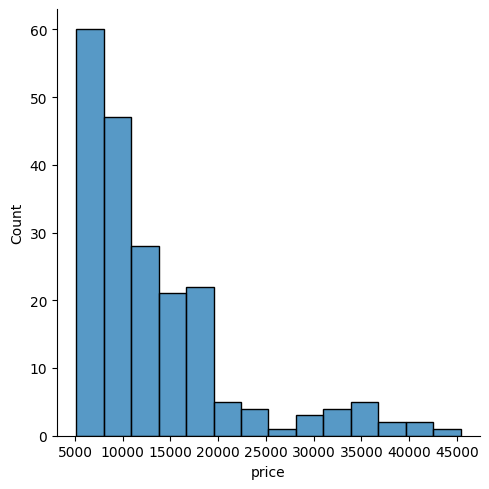

In [ ]:
sns.displot(y)

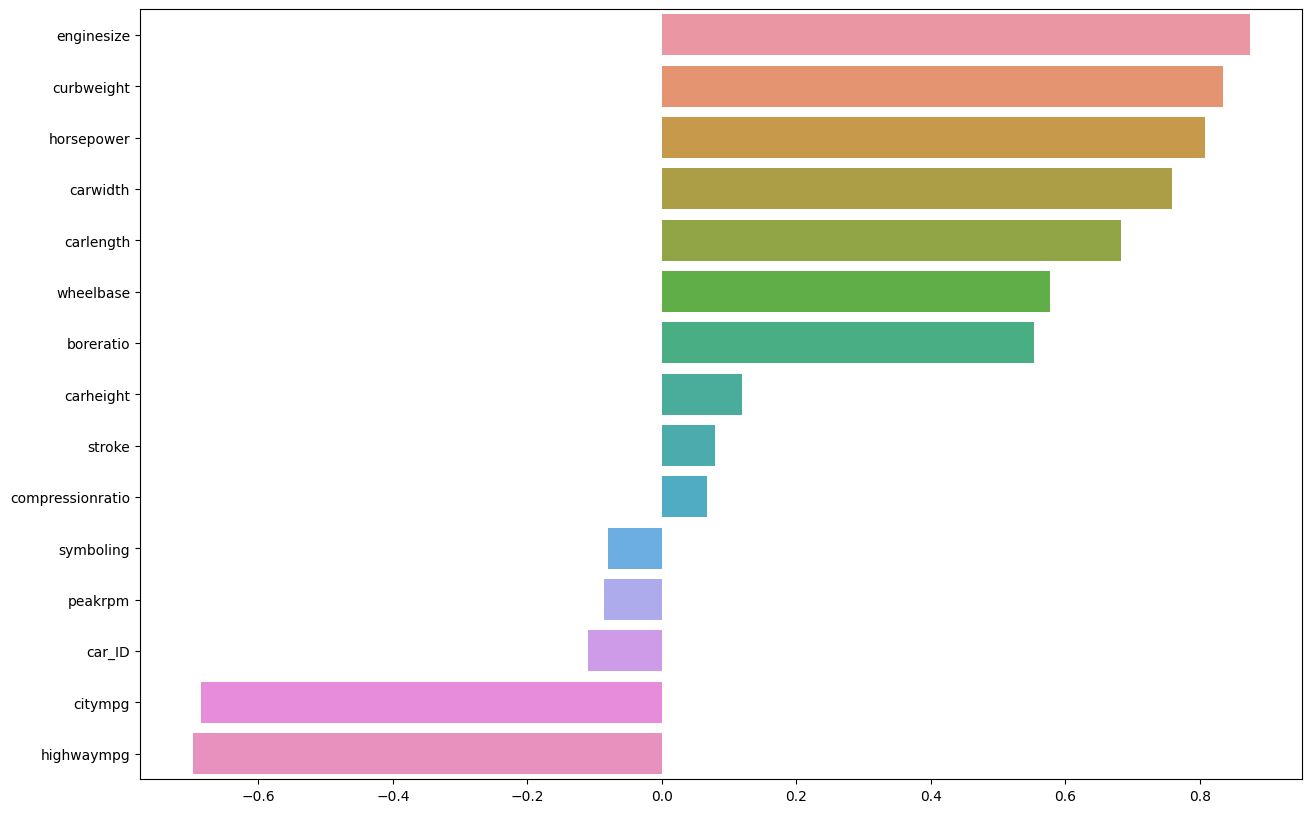

In [ ]:
correlations = X[numeric_features].corrwith(y).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### Randomized Search

In [ ]:
import numpy as np
from sklearn.model_selection import ShuffleSplit

class MyRandomizedSearchCV:
    def __init__(self, estimator, param_distributions, n_iter=10, cv=None, random_state=None):
        self.estimator = estimator
        self.param_distributions = param_distributions
        self.n_iter = n_iter
        self.cv = cv
        self.random_state = random_state
        
    def fit(self, X, y=None):
        random_state = np.random.RandomState(self.random_state)
        param_list = []
        for i in range(self.n_iter):
            params = {param_name: param_dist[random_state.randint(len(param_dist))] 
                      for param_name, param_dist in self.param_distributions.items()}
            param_list.append(params)
        self.param_list_ = param_list
        
        if self.cv is None:
            cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)
        else:
            cv = self.cv
        self.cv_results_ = []
        for params in param_list:
            estimator = self.estimator.set_params(**params)
            results = []
            for train_idx, test_idx in cv.split(X):
                X_train, y_train = X[train_idx], y[train_idx]
                X_test, y_test = X[test_idx], y[test_idx]
                estimator.fit(X_train, y_train)
                score = estimator.score(X_test, y_test)
                results.append(score)
            mean_score = np.mean(results)
            self.cv_results_.append({'params': params, 'mean_test_score': mean_score})
            
        self.best_params_ = max(self.cv_results_, key=lambda x: x['mean_test_score'])['params']
        self.best_estimator_ = self.estimator.set_params(**self.best_params_)
        return self

## Обучение

In [ ]:
import lightgbm

In [ ]:
model = lightgbm.LGBMRegressor()

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'n_estimators': [50, 100, 200],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
}

### My Randomized Search

In [ ]:
random_search = MyRandomizedSearchCV(model, param_grid, n_iter = 100)

In [ ]:
import time

In [ ]:
start1 = time.time()
random_search.fit(X_train, y_train)
end1 = time.time()

In [ ]:
score = max(random_search.cv_results_, key=lambda x: x['mean_test_score'])['mean_test_score']

In [ ]:
best_estimator = random_search.best_estimator_
best_params = random_search.best_params_

In [ ]:
y_pred = best_estimator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Best params:", best_params)
print("MSE:", mse)
print("R2:", r2)

Best params: {'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.0}
MSE: 10210492.974087313
R2: 0.8526292191870022


### Sklearn Randomized Search

In [ ]:
model1 = lightgbm.LGBMRegressor()

In [ ]:
search1 = RandomizedSearchCV(model1, param_grid, n_iter=100)

In [ ]:
start2 = time.time()
search1.fit(X_train, y_train)
end2 = time.time()

In [ ]:
best_estimator1 = search1.best_estimator_
best_params1 = search1.best_params_

In [ ]:
y_pred1 = best_estimator1.predict(X_test)
mse_1 = mean_squared_error(y_test, y_pred1)
r2_1 = r2_score(y_test, y_pred1)


print("Best params:", best_params1)
print("MSE:", mse_1)
print("R2:", r2_1)

Best params: {'subsample': 1.0, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
MSE: 4979916.465077609
R2: 0.9281235313804629


### Sklearn Bayes Search

In [ ]:
model2 = lightgbm.LGBMRegressor()

In [ ]:
from skopt.space import Real, Integer, Categorical

In [ ]:
param_grid_2 = {
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(3, 9),
    'reg_alpha': Real(0.0, 1.0, prior='uniform'),
    'reg_lambda': Real(0.0, 1.0, prior='uniform'),
    'subsample': Real(0.5, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),
    'min_child_weight': Real(0.1, 5, prior='uniform')
}


In [ ]:
search2 = BayesSearchCV(model2, param_grid_2, n_iter=10, cv = 5)

In [ ]:
start3 = time.time()
search2.fit(X_train, y_train)
end3 = time.time()

In [ ]:
best_estimator2 = search2.best_estimator_
best_params2 = search2.best_params_

In [ ]:
y_pred2 = best_estimator2.predict(X_test)
mse_2 = mean_squared_error(y_test, y_pred2)
r2_2 = r2_score(y_test, y_pred2)


print("Best params:", best_params2)
print("MSE:", mse_2)
print("R2:", r2_2)

Best params: OrderedDict([('colsample_bytree', 0.8149558838072066), ('learning_rate', 0.08556575579756467), ('max_depth', 4), ('min_child_weight', 1.3949362002936019), ('n_estimators', 74), ('reg_alpha', 0.5527975923663336), ('reg_lambda', 0.804123644128022), ('subsample', 0.7451633431625468)])
MSE: 6064754.09950637
R2: 0.912465779140015


### Сравнение

In [ ]:
data = [[100, None, score, end1-start1], [100, search1.best_index_+1, search1.best_score_, end2-start2], 
        [10, search2.best_index_+1, search2.best_score_, end3-start3]]

df = pd.DataFrame(data, columns=['Number of iterations', 'Best iteration', 'Best_score', 'Time'])
df.index = ['My Random Search', 'Sklearn Random Search', 'Bayesian Optimization']

In [ ]:
df

,Number of iterations,Best iteration,Best_score,Time
My Random Search,100,NaN,0.927551,8.284283
Sklearn Random Search,100,70.0,0.912033,8.297593
Bayesian Optimization,10,5.0,0.883296,2.091874
